# Aplicação para Modelagem de tópico

Neste exemplo, é utilizado um dataset de comentários em páginas da mídia e de personalidades midiáticas norte americanas.

### Definição de parâmetros
Para economizar tempo de execução, é recomendável não reprocessar o texto ou retreinar o algoritmo de clusterização caso não seja necessário.

Pode-se configuar a proporção da amostra, entre 0.0 e 1.0, para processar e treinar menos dados.

In [1]:
reprocess = True
retrain = False

sample = 1

## Imports

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from datetime import datetime
from utils import config
from utils.cleaner import message_cleaner
from utils.processing import naming, bigram_counts
from utils.inference import get_cluster_size, post_process, outliers, get_mode
from utils.GensimEstimator import SentenceVectorizer

pd.set_option('max_colwidth', 800)
pd.set_option('display.max_rows', 500)

In [3]:
df = pd.read_csv('extra/data.csv')[['created_time', 'message']]
df.created_time = pd.to_datetime(df.created_time, errors='coerce')
df = df.sort_values('created_time').sample(frac=sample).reset_index(drop=True) # organizar em ordem crescente de data
df.message.nunique()

952483

Amostra das mensagens

In [4]:
df[df.message.str.len() < 60].message.sample(10).reset_index(drop=True)

0              He doesnt believe in god i dont care what he says
1           The Nazi way. Accuse others of what you do yourself.
2                                                The Indoor Kids
3                                 What is the name of Thea ward?
4                                                     way to go!
5    Our beloved Screaming King, his majestic Donald Jerk Trump.
6     "Show your NRA membership and admission is free." - LMFAO!
7               Better than Beyoncé and her drug dealer husband!
8                                               Only 61. Hmnnnnn
9                        Where is Mark Twain when you need him??
Name: message, dtype: object

## Limpeza

In [5]:
if reprocess:
    df = message_cleaner(df, remove_blacklisted=True)
    df_backup = df.copy()

    with open(f"extra/cache/df.temp", "wb" ) as f: # salvar texto processado
        pickle.dump(df_backup, f)

else:
    with open(f"extra/cache/df.temp", "rb" ) as f:
        df = pickle.load(f)

Iniciando limpeza de texto
Removendo vazios
Proporção de duplicados removidos: 5.84 %
Salvando texto original
Removendo comentários que iniciam com nomes (duas palavras capitalizadas)
Transformando em caixa baixa
Removendo stopwords
Removidas palavras da lista de stopwords: 
Adicionadas palavras na lista de stopwords: 
Removendo excesso de espaços em branco, letras repetidas, símbolos e resquícios HTML
Removendo o que não é letra ou espaço em branco
Removendo comentários muito grandes ou pequenos
74868 frases com menos de 3 palavras foram removidas.
29381 frases com mais de 50 palavras foram removidas.
Restaram 745346 frases de um total de 849595.
Realizando substituições de sinônimos
Removendo frases com palavras da blacklist ou que não contenham as palavras obrigatórias
38.3% das frases foram removidas.
Removendo termos inúteis
Stemizando
Total de palavras únicas antes do stemming: 98121
Total de palavras únicas após stemming: 79293
Removendo excesso de espaço em branco, vazios e nul

Frequência de palavras resultantes da limpeza

In [6]:
from collections import Counter
all_words = ' '.join(df.message.to_list())
all_words = all_words.split()
main_words = [(i[0], i[1]) for i in Counter(all_words).most_common(200) if i[0] not in config.mandatory][:20]

df_sample = pd.DataFrame()
for word, n in main_words:
    sample = df.loc[df.message.str.contains(word)].sample(1)['message'].tolist()
    df_sample = df_sample.append(pd.DataFrame({'word': word, 'frequency': n, 'sample': sample}), ignore_index=True)
df_sample

,word,frequency,sample
0,trump,59267,barb insid gat named trump
1,peopl,46551,present government call persom soc security leach government see way government leach peopl tax every thing government steal tax pay tun trillion doll
2,lik,42217,lol trying appropriat insult lik deplorabl differenc hillary actually nasty even democrat liked
3,get,37660,com cnn get old your putting trump bash democrat show
4,would,32777,wish someon would grab nut vic pop lik balloom
5,one,30725,hop civil lawsuit pay big money
6,new,26414,fak fox new covering trump crim
7,know,25082,know worst parent generation kid really gonn messed kill children phenomen rat lik nev seen two kid one millenn got worried
8,need,24183,giv obam healthc trump healthc bill bad talk fool peopl gat peopl need fight right po peopl
9,tim,23425,ignorant nev opportunity learn something stupid opportunity learn taught school constitution tim learn campaign trail transition hiring advis profess listening stupid full know everything need know law spec stupid peopl voted still believ


## Modelagem

### Word2Vec

- min_count: quantidade mínima de vezes que uma palavra deve aparecer para ser incluída nos cálculos
- window: janela de palavras que será utilizada, 
- vector_size: dimensão do vetor gerado
- workers: número de núcleos utilizados
- sg: skip-gram

In [7]:
if retrain:
    w2v_model = SentenceVectorizer(min_count=10, window=7, vector_size=200, workers=8, sg=True)
    w2v_model.fit(df.message)
    X = w2v_model.transform(df.message)

    with open(f"extra/cache/w2v_model.temp", "wb" ) as f: # salvar texto processado
        pickle.dump(w2v_model, f)
    with open(f"extra/cache/X.temp", "wb" ) as f: # salvar texto processado
        pickle.dump(X, f)

else:
    with open(f"extra/cache/w2v_model.temp", "rb" ) as f:
        w2v_model = pickle.load(f)
    with open(f"extra/cache/X.temp", "rb" ) as f:
        X = pickle.load(f)

#### Análise de palavras

Total de palavras vetorizadas

In [8]:
word_count = pd.Series(' '.join(df.message).split()).value_counts()
word_count = word_count.loc[word_count > 10]
words = []
for index, word in enumerate(w2v_model.w2v.wv.index_to_key):
    words.append(word)
len(words)

16583

Para avaliar a qualidade da captura semântica do algoritmo, observar palavras similares a uma palavra aleatória

In [9]:
random_word = words[np.random.randint(0, len(words))]
print(random_word)
pd.DataFrame(w2v_model.w2v.wv.most_similar(random_word, topn=5), columns=['word', 'similarity'])

worried


,word,similarity
0,concerned,0.565797
1,worry,0.552912
2,pissed,0.515967
3,wondering,0.500264
4,scared,0.495389


Para as palavras mais frequentes, encontrar as palavras similares

In [10]:
w2v_model.w2v.wv.most_similar('desd', topn=2)

[('salud', 0.9765399694442749), ('eso', 0.9733166098594666)]

In [11]:
most_similar = []
for i in word_count.index[:10]:
    similar_word = w2v_model.w2v.wv.most_similar(i, topn=3)
    most_similar.append([i, similar_word[0][0], similar_word[1][0], similar_word[2][0]])
pd.DataFrame(most_similar, columns=['word', 'similar_1', 'similar_2', 'similar_3'])    

,word,similar_1,similar_2,similar_3
0,trump,dt,djt,drumpf
1,peopl,ppl,folk,citiz
2,lik,alik,fishy,mirr
3,get,getting,gotten,got
4,would,could,expected,might
5,one,every,nobody,person
6,new,report,breitbart,stori
7,know,both,think,understand
8,need,needed,want,wanting
9,tim,minut,week,month


### K-means

Clusterização

In [12]:
if retrain:
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=config.n_clusters)
    kmeans.fit(X)

    with open(f"extra/cache/lemmatized_kmeans.temp", "wb" ) as f: # salvar texto processado
        pickle.dump(kmeans, f)
else:
    with open(f"extra/cache/lemmatized_kmeans.temp", "rb" ) as f:
        kmeans = pickle.load(f)

Predições

In [13]:
predictions = kmeans.predict(X)

Marcação de outliers

In [14]:
df['outlier'] = outliers(X, kmeans, predictions, percent_outliers=5)

Nomear clusters

In [15]:
df_bigram_counts = bigram_counts(kmeans, df)
df_cluster_names = naming(df_bigram_counts)

Há termos duplicados na atribuição dos clusters (config.clusters)
Subclusters não agregados a um cluster:
0                             [mak sens, mak sur, mak look, would mak]
1                        [one word, speak english, key word, two word]
2                         [alex jon, bye bye, sir cart, chril christi]
3             [nothing burg, nothing wrong, nothing see, know nothing]
4                            [look lik, ye old, sound lik, pretty sur]
5                            [tak car, need tak, going tak, giv break]
6                     [god bles, thank god, bles amer, bles president]
7                      [amer great, mak amer, making amer, amer first]
8                              [really car, car les, one car, tak car]
9                       [look lik, trump support, con man, con artist]
10               [win win, next election, win election, lost election]
11                    [repe replac, repe obamac, full repe, repe repe]
12                             [good job, 

### Análise da clusterização

<Axes: ylabel='Count'>

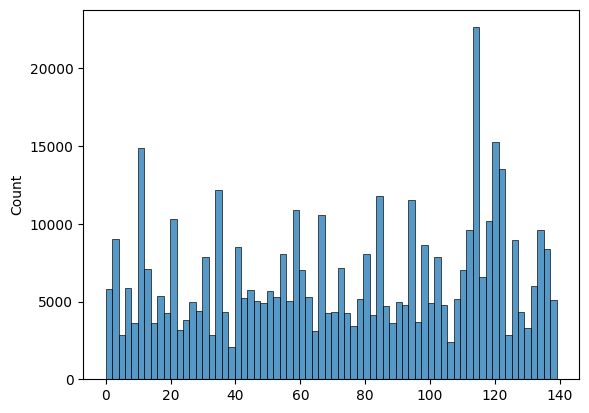

In [16]:
sns.histplot(kmeans.labels_)

In [17]:
clusters = df_cluster_names[['subclusters_id', 'cluster']]

In [18]:
clusters = get_cluster_size(kmeans, clusters)

Preview das frases classificadas

In [19]:
df_phrases = pd.concat([df, pd.Series(predictions, name='subclusters_id')], axis=1)
df_phrases = pd.merge(df_phrases, clusters)
df_phrases.loc[df_phrases.outlier == 0].sort_values('original_message')[['message', 'original_message', 'outlier', 'cluster']].sample(10)

,message,original_message,outlier,cluster
127059,public would benefit watching hand probably get cuz mean vindictiv vengeful hateful,"The publicans would benefit from watching this...on the other hand they probably won't get it cuz they are so mean, vindictive, vengeful, hateful and in it for themselves",0,None
188983,stopped translating meeting stopped showing nic,"They stopped translating the meeting, now stopped showing it. Nice.",0,Donald Trump
276177,im feeling blu send piec garbag nasty tweet least day blocked wrong,"Im feeling very blue ... I send this piece of garbage a nasty tweet at least once a day, and he hasn't blocked me. WHAT'S WRONG WITH ME???? 😰",0,None
307815,percent country lov fascist moron sur ev car don month continu forget lov uneducated lov,40percent of the country LOVES this fascist moron. I'm not at all sure they will ever care what he has done (in 6 months.) and will continue to do. Don't forget he loves the uneducated! They love him.,0,United States
196583,talk stupid dumb looking guy really know mak as,Talk about stupid and dumb looking this guy has it all. He really knows how to make an ass out of himself.,0,Swearing
6149,th century throwback need disapp soil,These 15th century throwbacks need to disappear from our soil.,0,None
316705,abenomic awesom peopl losing faith,Isn't Abenomics awesome?! Why are people losing faith in him?,0,United States
165979,yep clas act,Yep a class act!,0,None
179014,holy crap get greg north kore po guy,"Holy crap ,get Greg out of North Korea ,poor guy.",0,North Korea
292035,liberal want amer liberal death amer she stupidity ignoranc,This is what liberals want here in America. Liberals will be the death of America out of shear stupidity and ignorance,0,Left wing


Adicionar predições e renomear clusters nulos

In [20]:
df_clustered = post_process(predictions, clusters, df)

Amostra de clusters classificados

In [21]:
df_oneach = pd.DataFrame()
for k, v in config.clusters.items():
    try:
        df_oneach = pd.concat([df_oneach, df_clustered.loc[df_clustered.label == k].sample(1)])
    except:
        continue
df_oneach

""


Plot da quantidade de mensagens por cluster

cluster
United States              36826
Fake News                  27931
Donald Trump               27167
Social Politics            18965
News/TV                    13695
Climate Change             13537
Taxes                      11648
Middle East                 7275
Political Parties           7216
Clinton                     6584
Right wing                  5984
Government                  5495
Swearing                    4643
Believing anything          4606
Freedom of speech           3883
Election                    3439
Justice/Law enforcement     3372
Barack Obama                3351
Left wing                   3178
War                         2994
Russia                      2660
White people                2625
Paul Ryan                   2483
Sex assault                 2456
Education                   2449
Diet                        2386
Crime                       2258
Compliments                 2133
Death penalty               2069
North Korea                 1534
US

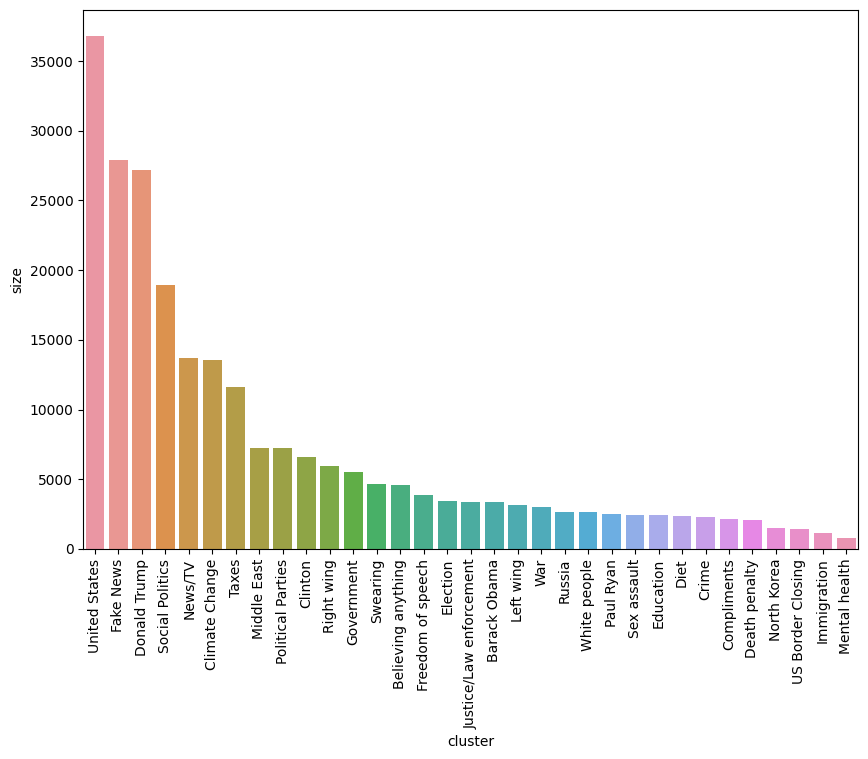

In [37]:
plt.figure(figsize=(10,7))
clusters = df_clustered.groupby('cluster').count()['size'].sort_values(ascending=False)
sns.barplot(x=clusters.index, y=clusters)
plt.xticks(rotation=90);

Comparação entre as mensagens e os bigramas de seus clusters

In [ ]:
df_clustered.loc[~df_clustered.cluster.isna()].sample(5).merge(df_cluster_names[['subclusters_id', 'split_message']])[['message', 'original_message', 'outlier', 'subclusters_id', 'cluster', 'size', 'split_message']]

,message,original_message,outlier,subclusters_id,cluster,size,split_message
0,democrat put obamac republic think obligated keep let die replac howev congres mak easi health insuranc provid sell nationwid,Why? Democrats put in Obamacare and now Republicans think they are obligated to keep it? Let it die and do not replace it. However Congress should make it easier for Health insurance providers to sell Nationwide.,0,103,Social Politics,5124,"[health car, healthc bill, car bill, obam car]"
1,know sick ris lov crim hat law abiding tax paying legal citiz,We KNOW and we are so sick of it. Rise up against the lovers of the criminals and haters of law abiding tax paying legal citizens.,0,26,Justice/Law enforcement,2477,"[law enforcement, rul law, break law, sh law]"
2,tim wish could still ston peopl death two deserving death stoning,Some times I wish we could still stone people to death. These two are deserving of a death by stoning.,0,19,Death penalty,2069,"[death penalty, death panel, get death, death sentenc]"
3,much long going keep pretending main pag still tuesday hack,How much longer are you going to keep pretending that the main page is still down because of the Tuesday hack?,0,134,Fake News,7944,"[fak new, fox new, president trump, new med]"
4,nothing say allah protect peopl non els,Nothing to say. Allah will protect the people. None else,0,137,Believing anything,4606,"[believ anything, say anything, anything say, trump say]"


### Análise de frases não classificadas

In [ ]:
unclustered = df_cluster_names.loc[df_cluster_names.cluster.isna()]['split_message']
unclustered

1                              [mak sens, mak sur, mak look, would mak]
5                         [one word, speak english, key word, two word]
7                          [alex jon, bye bye, sir cart, chril christi]
9              [nothing burg, nothing wrong, nothing see, know nothing]
10                            [look lik, ye old, sound lik, pretty sur]
13                            [tak car, need tak, going tak, giv break]
14                     [god bles, thank god, bles amer, bles president]
15                      [amer great, mak amer, making amer, amer first]
18                              [really car, car les, one car, tak car]
20                       [look lik, trump support, con man, con artist]
21                [win win, next election, win election, lost election]
22                     [repe replac, repe obamac, full repe, repe repe]
23                              [good job, great job, get job, nut job]
24              [elected offic, oval offic, polic offic, removed

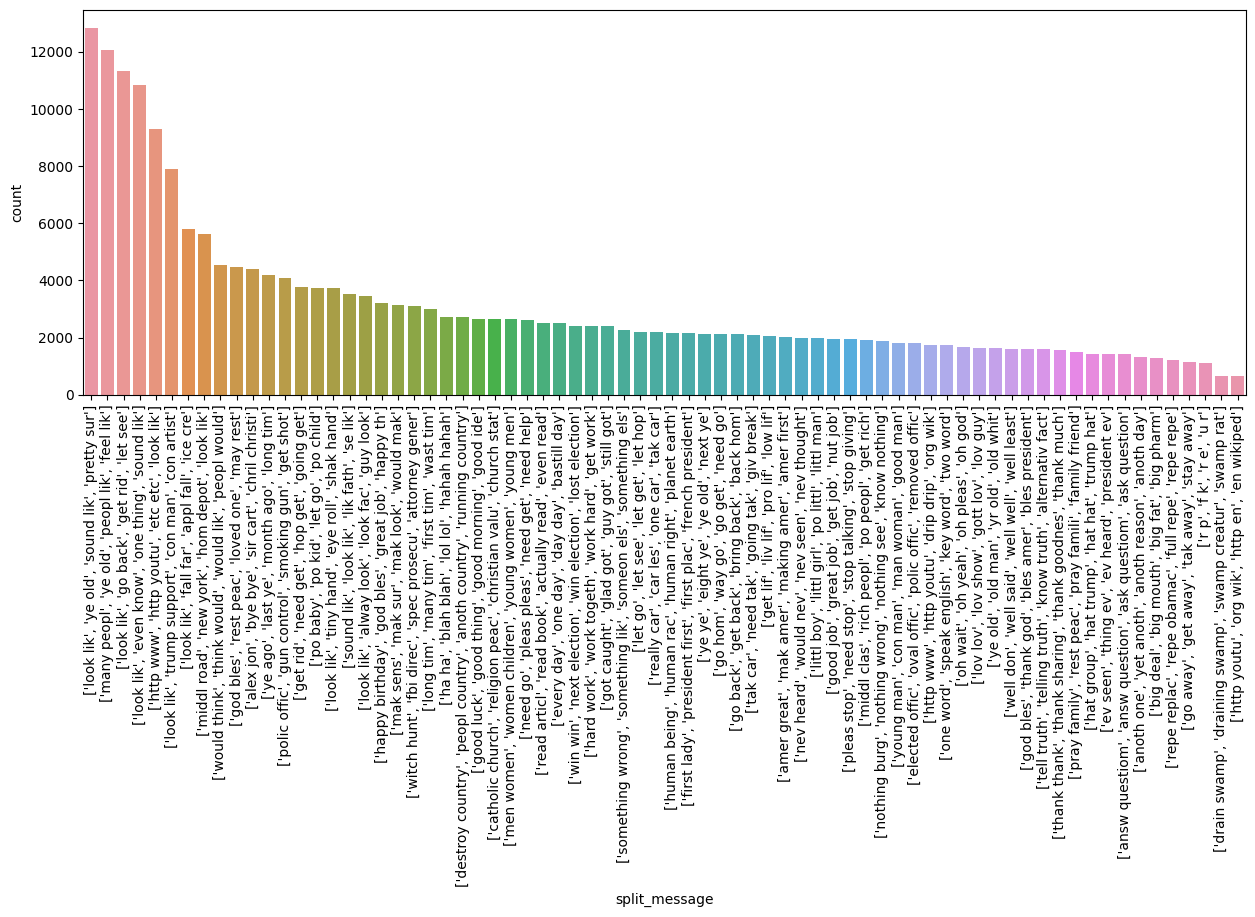

In [ ]:
df_unclustered = df_clustered.loc[df_clustered.cluster.isna()].merge(df_cluster_names[['subclusters_id', 'split_message']])
df_unclustered['split_message'] = df_unclustered['split_message'].astype(str)
plt.figure(figsize=(15,5))
sns.countplot(data=df_unclustered, x='split_message', order=df_unclustered.split_message.value_counts().index)
plt.xticks(rotation=90);


In [ ]:
for i in unclustered.index:
    tokens_near_center = ''
    most_representative = w2v_model.w2v.wv.most_similar(positive=[kmeans.cluster_centers_[i]], topn=10)
    for t in most_representative:
        tokens_near_center += f" {t[0]} ,"
    print(f"Cluster {i}: {tokens_near_center}")

Cluster 1:  mak , making , mad , common , humour , think , know , want , knowing , convinc ,
Cluster 5:  word , speak , languag , intelligently , phras , conversation , contradict , transla , acknowledg , english ,
Cluster 7:  tyl , steven , meliss , mitchell , kati , patrick , nicol , harvey , sandr , shapir ,
Cluster 9:  nothing , anything , something , flipp , everything , admit , exactly , obstruct , burg , proven ,
Cluster 10:  ticked , strang , wondered , know , toned , analyz , honestly , taping , physiqu , liked ,
Cluster 13:  tak , taking , giv , taken , get , throw , giving , pull , walk , given ,
Cluster 14:  god , blessing , blessed , praying , amen , pray , bles , thankful , allah , heaven ,
Cluster 15:  amer , country , succeed , democracy , americ , american , destroying , mag , dictatorship , destroy ,
Cluster 18:  car , insuranc , cared , affordabl , afford , benefit , healthc , want , worry , matt ,
Cluster 20:  ignorant , clueles , imbecil , arrogant , egotistic , un

In [ ]:
df_oneach = pd.DataFrame()
for k in unclustered.index:
    try:
        df_oneach = pd.concat([df_oneach, df_clustered.loc[df_clustered.subclusters_id == k].sample(1)])
    except:
        continue
pd.merge(df_oneach[['message', 'original_message', 'subclusters_id', 'size']], df_cluster_names, on='subclusters_id')

,message,original_message,subclusters_id,size,split_message,cluster
0,going try mak peopl successful turn back collectivism dre,'We're going to try and make people so successful they'll turn their backs on collectivism.' Now that's a dream I can have!,1,3138,"[mak sens, mak sur, mak look, would mak]",None
1,peopl nasty many languag speak appearanc savvy person unlik demean oth,Why do people have to be so nasty to her. How many languages do you speak? She is by all appearances a savvy person. Unlike most here she did not and does not demean others.,5,1729,"[one word, speak english, key word, two word]",None
2,gearld ford sequel,Who is the Gearld Ford in this sequel?,7,4395,"[alex jon, bye bye, sir cart, chril christi]",None
3,much ado nothing nic recovery,Much ado about nothing... nice recovery,9,1894,"[nothing burg, nothing wrong, nothing see, know nothing]",None
4,dictatorship happen one day next well thought blueprint laid implemented lat exactly hitl started wanted mak germany great peopl cheered,"Most dictatorships did not happen from one day to the next, a well thought out blueprint was being laid out and when it was implemented it WAS TOO LATE! This is exactly how Hitler started, he wanted to make Germany great again and the people cheered!",10,12826,"[look lik, ye old, sound lik, pretty sur]",None
5,execut deal giv addict treatment continu taking drug giv lash bullwhip,Execute the dealers and give the addicts treatment. If they continue taking drugs...give the 40 lashes with a bullwhip.,13,2108,"[tak car, need tak, going tak, giv break]",None
6,god real peopl mystery,"God isn't real, people are. What's the mystery?",14,1601,"[god bles, thank god, bles amer, bles president]",None
7,american truly hop europ fully depend amer geez tak car,"As an American, I truly hope that Europe will not ""fully depend"" on America. Geez, take care of yourselves.",15,2029,"[amer great, mak amer, making amer, amer first]",None
8,rating already crapp car,Their ratings were already in the crapper who cares.,18,2191,"[really car, car les, one car, tak car]",None
9,witch sist whining break law called whin lik pig pathetic,"The WITCH is his sister and him whining about it. They all break laws then when called out, they whine like a PIG. Pathetic!",20,7892,"[look lik, trump support, con man, con artist]",None


Text(0, 0.5, 'Counts')

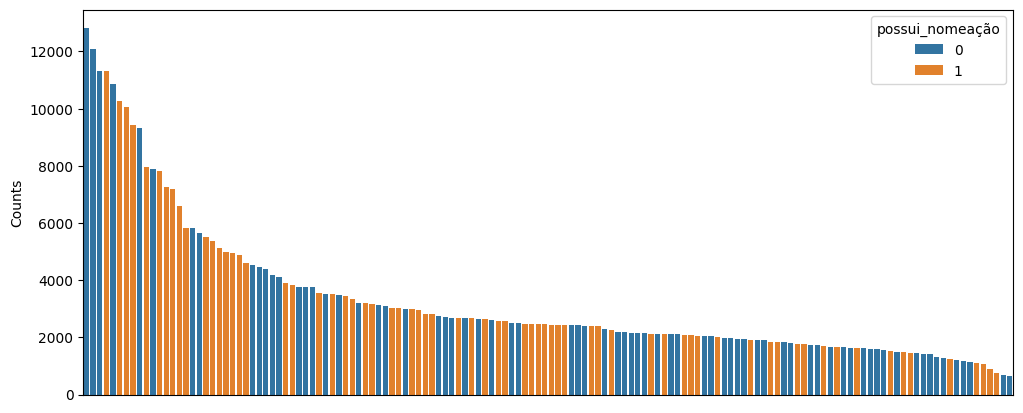

In [ ]:
temp = df_clustered.copy()
temp['has_label'] = np.where(temp.cluster.isna(), 0, 1)
temp_counts = pd.DataFrame(temp.subclusters_id.value_counts())
temp_counts = temp_counts.merge(temp.groupby('subclusters_id').agg(possui_nomeação=('has_label', 'max')), left_index=True, right_index=True)
temp_counts = temp_counts.reset_index()
plt.figure(figsize=(12,5))
ax = sns.barplot(data=temp_counts, x=temp_counts.index, y='subclusters_id', hue='possui_nomeação', dodge=False)
plt.xticks(rotation=90);
plt.xticks([]);
plt.ylabel('Counts')

In [ ]:
df_clustered[df_clustered.subclusters_id == 10]

,created_time,from_id,from_name,message,post_name,original_message,outlier,subclusters_id,cluster,size
265181,2015-04-09 13:27:17+00:00,a6c3bd9e3c9e21281e71,8f1b20aec44412674352,lov could don without lemon phot,a6c3bd9e3c9e21281e71_1556268194635647,Love you but could have done without Don Lemon in this photo!,0,10,None,12826
265182,2015-06-10 20:00:34+00:00,c7750ef43df1c8b69ce4,49a2102d69d8fcbf854f,interview dugg daught well don genuin lovely girl needed get fact lie going around damaging family law indeed broken victimized tim wors see interview,c7750ef43df1c8b69ce4_1578608945734905,"The interview with the Duggar daughters was well-done. They are very genuine, lovely girls who just needed to get the facts out there. The lies going around are so damaging to this family. The law was indeed broken and they were victimized all over again and this was ""1000 times worse"" for them, as you can see from the interview.",0,10,None,12826
265183,2017-07-10 07:52:14+00:00,01bb70b6a161fb035fdd,7c791e727acd2b64cacd,pictur executiom empj would als lik request hanged man axe head chopping quartering wheel drowning cag crucifiction treated spec,01bb70b6a161fb035fdd_10155755757259411,"If we do pictures of executions as empji, I would also like to request hanged man, axe head chopping, quartering in wheel and drowning in a cage. Why should crucifiction be treated any special...",0,10,None,12826
265184,2017-07-11 16:41:48+00:00,e4f2a6202287cccb545e,6ca712fcc786fcf88f85,let see describ sigm bigoted cold hearted ignorant list goe day,e4f2a6202287cccb545e_10155621810478010,"Lets see how to describe these signs ;bigoted, cold hearted, ignorant and the list just goes on for days.",1,10,None,12826
265185,2017-07-13 21:51:51+00:00,fc5fd9f543533477f351,4600bedf1d344f1b43db,awful preferred long,fc5fd9f543533477f351_2539983626061370,It's awful I preferred it long,1,10,None,12826
...,...,...,...,...,...,...,...,...,...,...
278002,2017-07-10 16:34:19+00:00,ef59c4c3062477c110a2,a23c24d950f479e2a6a0,way already know woman story beast today mak cle enjoy florenc color,ef59c4c3062477c110a2_10155633241919203,There is no way that you didn't already know who this woman was. The other story in The Beast today makes that clear. Enjoy Florence Colorado.,0,10,None,12826
278003,2017-07-09 13:24:10+00:00,be6a414220c0ac3c3a87,fd1c84daf5efcb0c8d59,part elish call grizzly be wood maul kill kid called baldy thought,be6a414220c0ac3c3a87_10154707664681680,"Is it the part where Elisha calls 2 Grizzly Bears from the woods to maul and kill 42 kids because they called him ""Baldy""? I thought not... 😂",0,10,None,12826
278004,2017-07-13 10:07:04+00:00,6b62612fb24794f0ff13,25e0bcc8fe3a76fca4bb,one many misinformation milliom know truth buy rwandan descent tuts hutu lived cong jungl ye really happened happ world mad believ two distinct scenari check earn bit bbc documentary rwand untold story giv light really happened,6b62612fb24794f0ff13_10155767061909411,"This is one of the many misinformation out there and millions who do not know the truth will buy it, I am Rwandan, descent of both tutsi and hutu, lived in the congo jungle for over 10years. What really happened/happens and what the world is made to believe are two very distinct scenarios. Check out this and earn a bit, BBC documentary: Rwanda untold story. It gives some light on what really happened.",0,10,None,12826
278005,2017-06-30 13:04:09+00:00,c5fa14959ec52dc8795d,62012db5b5dce71021e6,pretty telling waited guy air,c5fa14959ec52dc8795d_10155483349071880,Pretty telling he waited until just after you guys were off the air,0,10,None,12826


In [ ]:
temp_counts

,index,subclusters_id,possui_nomeação
0,10,12826,0
1,122,12075,0
2,114,11327,0
3,115,11304,1
4,94,10848,0
5,121,10258,1
6,34,10040,1
7,119,9441,1
8,85,9313,0
9,134,7944,1


Amostras de cluster não identificados

In [ ]:
df_oneach = pd.DataFrame()
for k in temp_counts.loc[temp_counts.has_label == 0]['index']:
    try:
        df_oneach = pd.concat([df_oneach, df_clustered.loc[df_clustered.subclusters_id == k].sample(1)])
    except:
        continue
oneach = pd.merge(df_oneach[['message', 'original_message', 'subclusters_id', 'size']], df_cluster_names, on='subclusters_id')
oneach.sort_values('size', ascending=False)

,message,original_message,subclusters_id,size,split_message,cluster
0,well glaci iceberg alway moving norm happ quit regularly scal tim,"Well, glaciers and icebergs are always moving..this is normal and happens quite regularly on the scale of time",10,12826,"[look lik, ye old, sound lik, pretty sur]",None
1,need basic intelligenc test polic woman look lik man stupid job period,"We need a basic intelligence test for police. If a 5'2"" woman looks like a 5'10"" man, you're too stupid for the job, period.",122,12075,"[many peopl, ye old, peopl lik, feel lik]",None
2,best thing piec keep hill bipartisan me hopefully right pay attention shitshow reported daily let go ahead,The best thing about these pieces is it keeps the hill being bipartisan . Which means hopefully the right will pay attention to the shitshow being reported on daily. \r\n\r\nLet them have it. Go ahead.,114,11327,"[look lik, go back, get rid, let see]",None
3,oop think braim would figur good thing mommy daddy didnt many brain cell easy cleanup,oops .. you'd think with 3 brains they all would figure out not to do this.. good thing mommy and daddy didnt have many brain cells so it was an easy cleanup,94,10848,"[look lik, even know, one thing, sound lik]",None
4,put chipping are putting green north lawn wh start holding ann monic lewinsky memor beauty pageant chipping putting skill fashion contest current interm say need draw lin say,"When he puts in a chipping area with a putting green out in the North Lawn @ the WH & then he starts holding annual Monica Lewinsky Memorial beauty pageants with chipping & putting skill/fashion contests for current interns, I say that's where we need to draw the line. What say you?",85,9313,"[http www, http youtu, etc etc, look lik]",None
...,...,...,...,...,...,...
67,option build aca work effectively stop trying destroy aca,"The other option is to build on the ACA , so it works more effectively. Stop trying to destroy the ACA.",22,1218,"[repe replac, repe obamac, full repe, repe repe]",None
68,go away hannity passed shelf lif,"Go away Hannity , you are passed your shelf life!!",130,1164,"[go away, get away, tak away, stay away]",None
69,kest c chau,Kester C. Chau,107,1129,"[r p, f k, r e, u r]",None
70,peopl fed establishment need drain swamp,We the people were and are fed up with the establishment now we need to drain the swamp!,95,672,"[drain swamp, draining swamp, swamp creatur, swamp rat]",None


Fração da base não classificada

In [ ]:
oneach['size'].sum()/df_clustered.drop_duplicates(subset=['subclusters_id'])['size'].sum()

0.4838562165161156

In [ ]:
pd.DataFrame(df_clustered.sample(20).groupby('original_message').apply(get_mode)).rename(columns={0:'Moda'})

,Moda
original_message,
All of these folks need to be in prison. The wrath of trump is about to be unleashed on the very people that voted for him. He is about to give you all pure hell. #25thAmendment,United States
B.s.. couldn't be elected for dog catcher,Swearing
Can we just cancel Brexit and save the pain?,Social Politics
Fake news for fake people,Fake News
Go to hell you Trump hating piece of crap! Go to CNN where you belong!,None
Good luck Megyn Kelly...I'm still with you even though you were hard on Donald J. Trump...I left the Dems for someone who will really chane things!!!!!,News/TV
How does this work if the world is flat?,Freedom of speech
"I'd like to see Megyn Kelly ""get"" Stormed, 🤑 by dozens of troopers 🤓",News/TV
If that was my father being punched that little bastard had better hide!!!!😥😥😥😥😥😡😡😡😡,None
